In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
pre_train = 10
epoch = 3000
path = 'results/training/'
tasks = ['push', 'hit', 'stack']
#models = ['b1', 'b2', 'lp',  'lpe-k=0.1', 'lpe-k=1', 'lpe-k=10']
# models = ['singletask', 'imtl-rand', 'imtl-lp']
models = ['imtl-lp', 'imtl-lp-5', 'imtl-lp-10', 'imtl-lp-v2', 'imtl-lp-5-v2']

In [3]:
# seed = 0
# model_name = "lpe-k=1-seed-{}".format(seed)
# lp_history = np.load(f'{path}/lp-values-{model_name}.npy')
# ep_history = np.load(f'{path}/ep-values-{model_name}.npy')
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].plot(lp_history[0], label='push')
# ax[0].plot(lp_history[1], label='stack')
# ax[0].plot(lp_history[2], label='hit')
# ax[0].set_title('LP history')
# ax[0].legend()
# 
# ax[1].plot(ep_history[0], label='push')
# ax[1].plot(ep_history[1], label='stack')
# ax[1].plot(ep_history[2], label='hit')
# ax[1].set_title('EP history')
# ax[1].legend()
# plt.show()

In [4]:
num_seeds = 10
seeds = [9236, 1681, 3342, 7387, 3815, 1740, 1194, 3893, 4552, 6278]
task_losses_seeds = np.zeros((num_seeds, len(models), 3, epoch + pre_train))
task_energies_seeds = np.zeros((num_seeds, len(models), 3))
model_losses_seeds = np.zeros((num_seeds, len(models), epoch + pre_train))
model_energies_seeds = np.zeros((num_seeds, len(models)))

In [5]:
mode = 'train'

<Figure size 640x480 with 0 Axes>

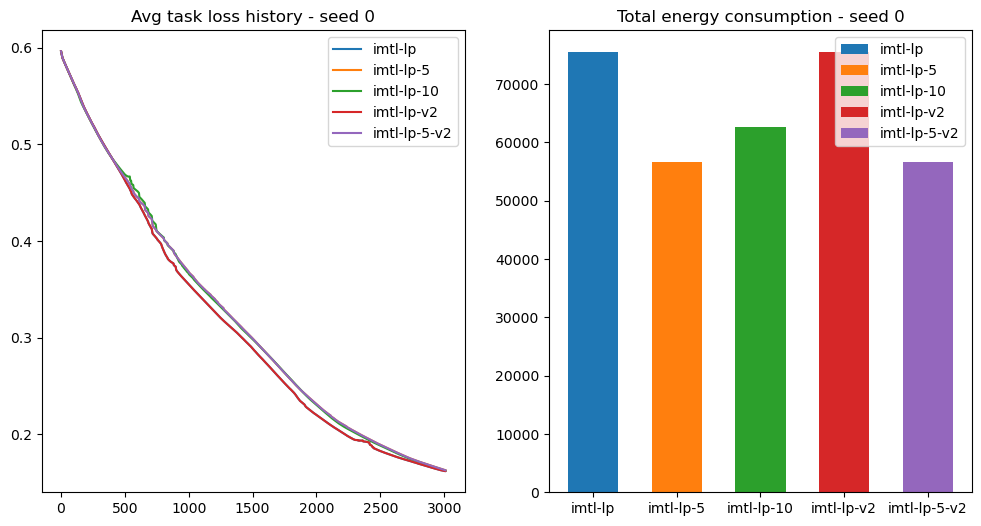

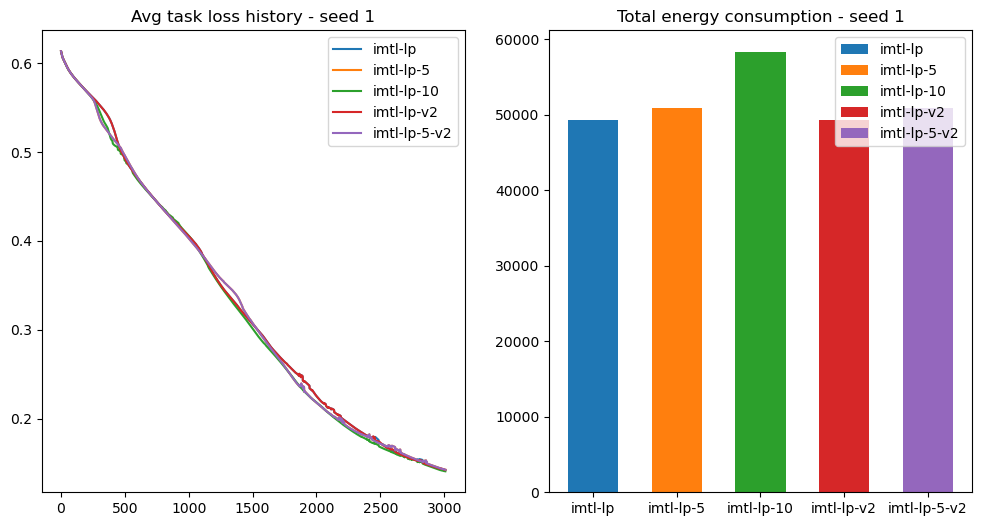

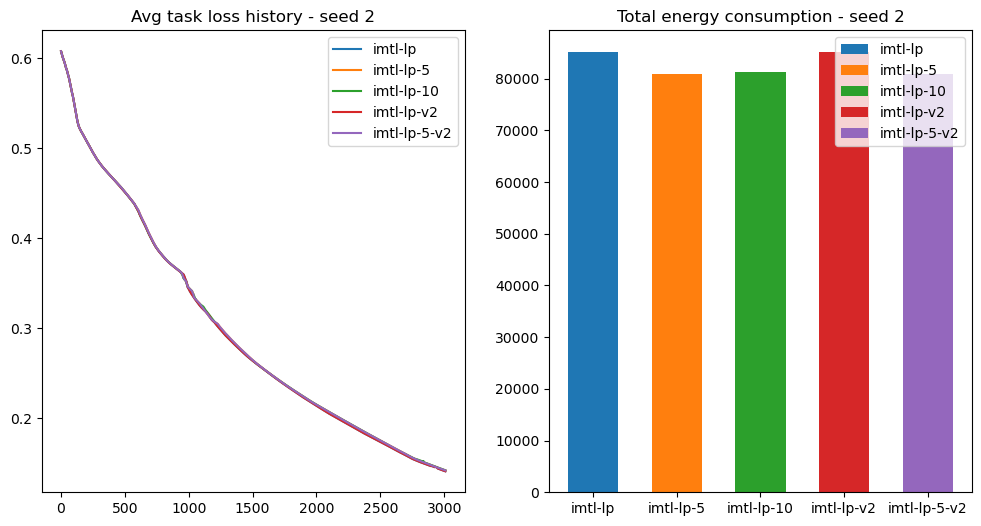

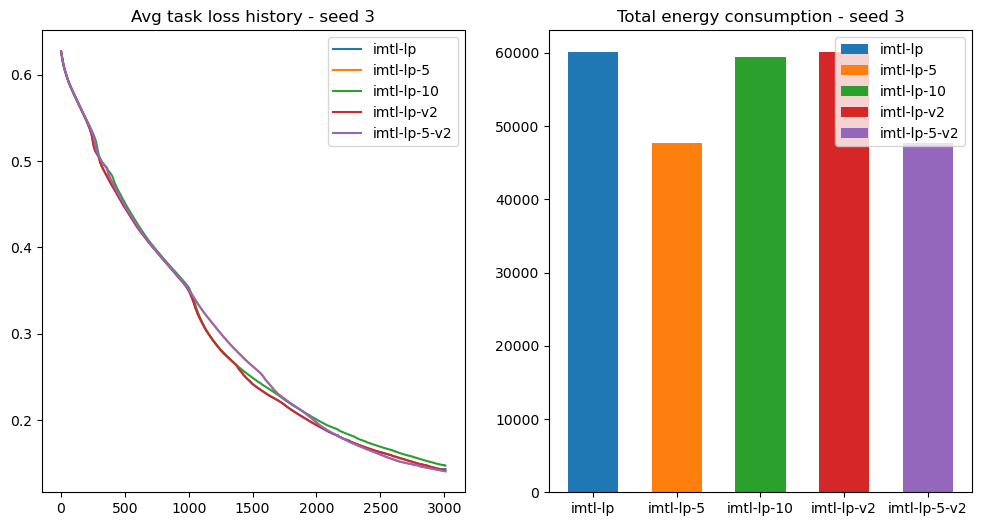

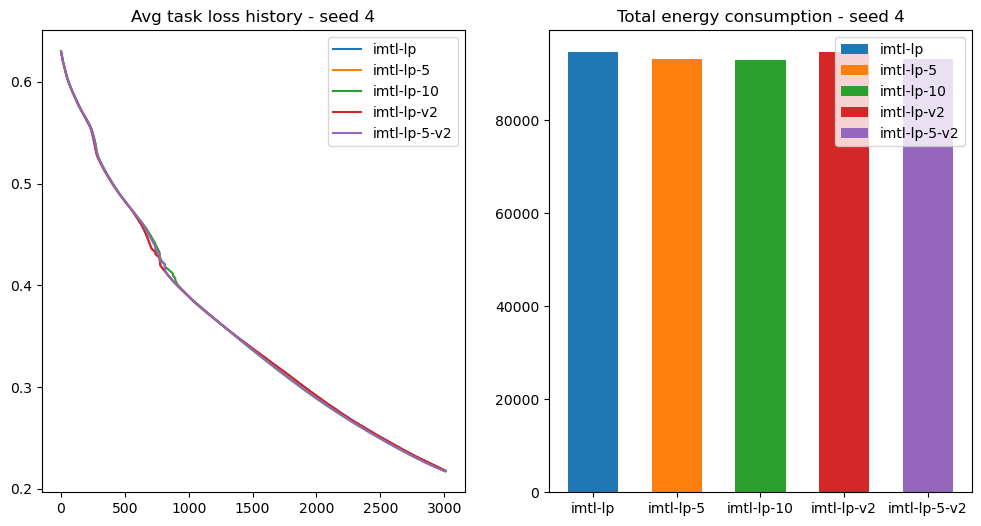

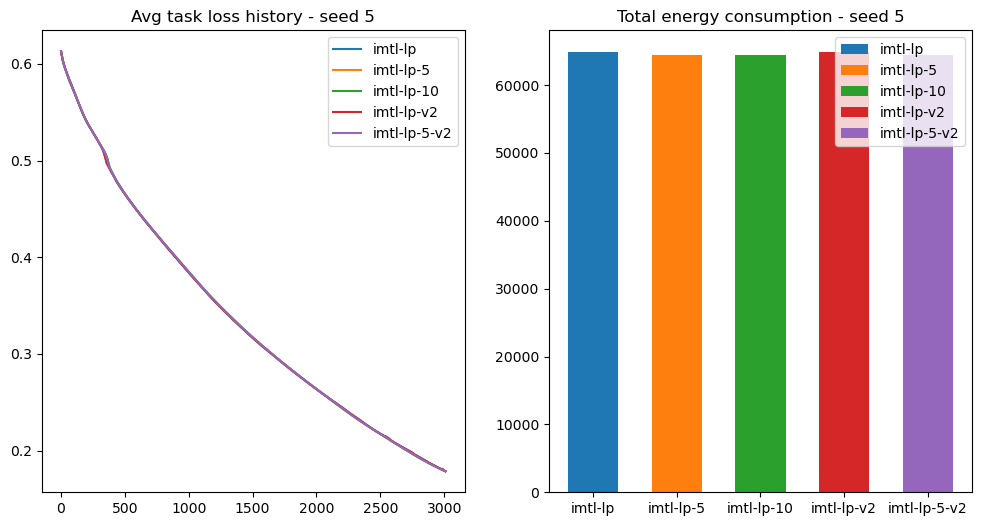

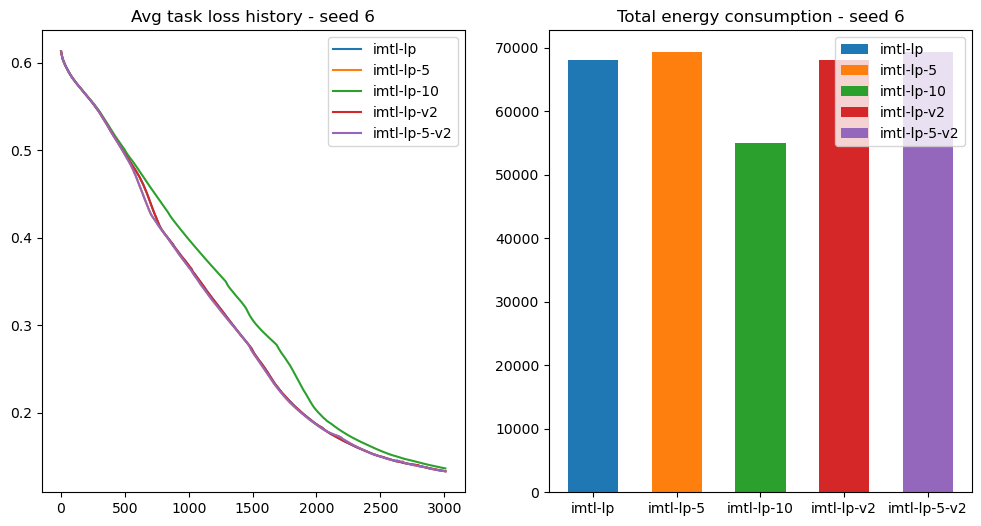

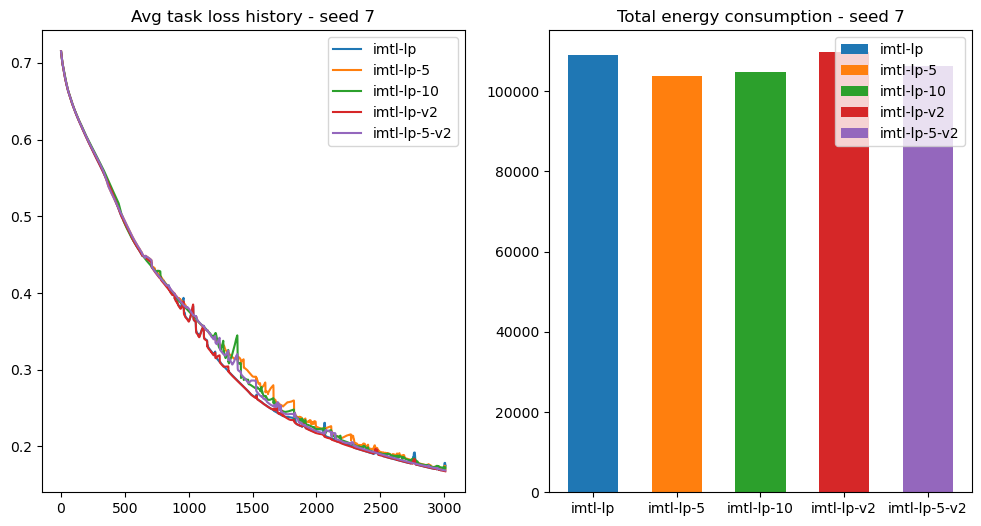

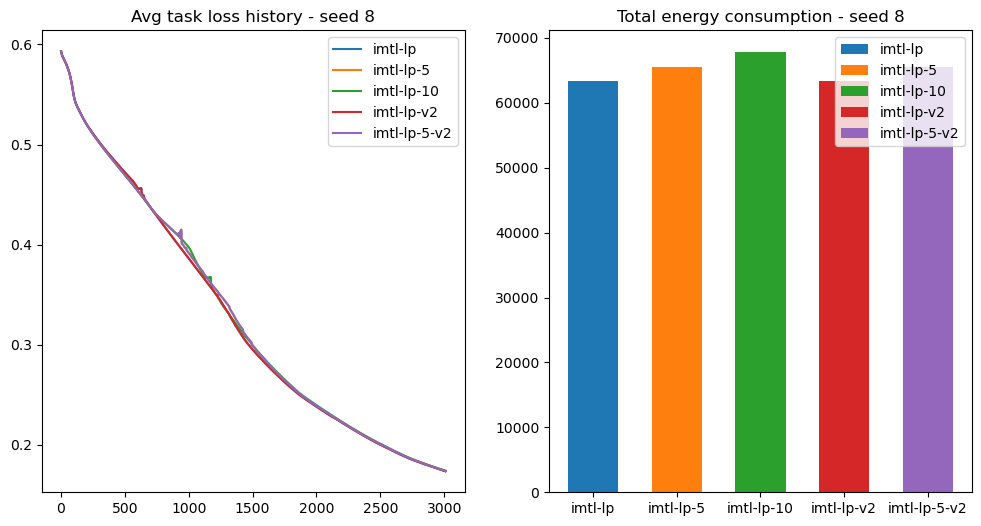

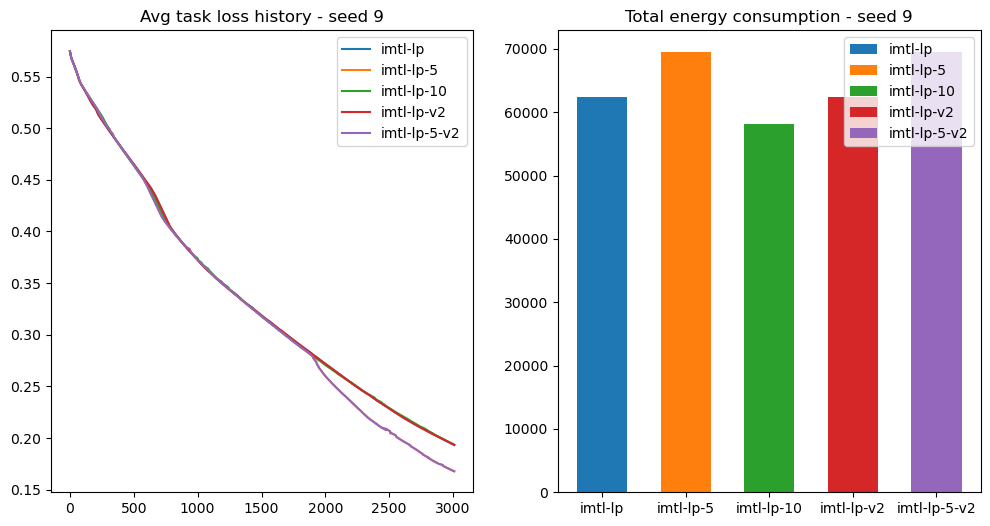

In [6]:
plt.figure(1)
for s, seed in enumerate(seeds):
  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
  for i, model in enumerate(models):
    loss_data = np.load('{}/plots/{}-loss-plot-seed-{}.npy'.format(path + model, mode, seed), allow_pickle=True)[:, :epoch + pre_train]
    energy_data = np.load('{}/plots/{}-energy-bar-epoch-{}-seed-{}.npy'.format(path + model, mode, epoch, seed), allow_pickle=True)  # shape: task count
    avg_task_loss = np.mean(loss_data, axis=0)
    for j in range(3):  # number of tasks
        task_losses_seeds[s][i][j] = loss_data[j]
        task_energies_seeds[s][i][j] = energy_data[j]
    model_losses_seeds[s][i] = avg_task_loss
    total_energy = np.sum(energy_data)
    model_energies_seeds[s][i] = total_energy

    ax1.plot(range(epoch + pre_train), avg_task_loss, label="{}".format(model))
    ax2.bar(model, total_energy, width=0.6, label="{}".format(model))
    ax1.legend()
    ax1.set_title('Avg task loss history - seed {}'.format(s))
    ax2.legend()
    ax2.set_title('Total energy consumption - seed {}'.format(s))

plt.show()

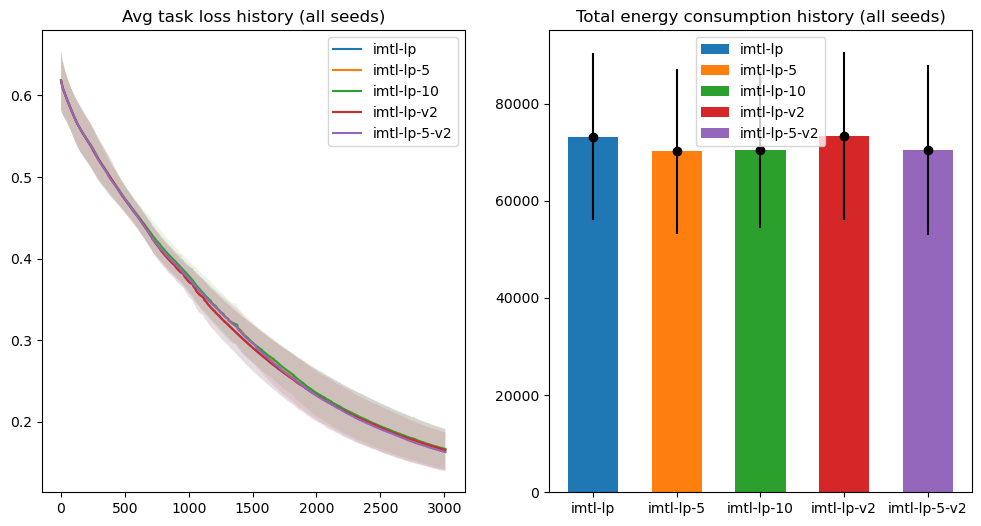

In [7]:
# All seeds model avg
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
model_loss_mean = np.mean(model_losses_seeds, axis=0)
model_loss_std = np.std(model_losses_seeds, axis=0)
model_energy_mean = np.mean(model_energies_seeds, axis=0)
model_energy_std = np.std(model_energies_seeds, axis=0)
for i, model in enumerate(models):
    ax1.plot(range(epoch + pre_train), model_loss_mean[i], label="{}".format(model))
    ax1.fill_between(range(epoch + pre_train), model_loss_mean[i] - model_loss_std[i],
                     model_loss_mean[i] + model_loss_std[i], alpha=0.1)
    ax2.bar(model, model_energy_mean[i], width=0.6, label="{}".format(model))
    ax2.errorbar(model, model_energy_mean[i], yerr=model_energy_std[i], fmt="o", color="black")
ax1.legend()
ax1.set_title('Avg task loss history (all seeds)')
ax2.legend()
ax2.set_title('Total energy consumption history (all seeds)')
# plt.savefig('plotresults/allseeds.png')
plt.show()

<Figure size 640x480 with 0 Axes>

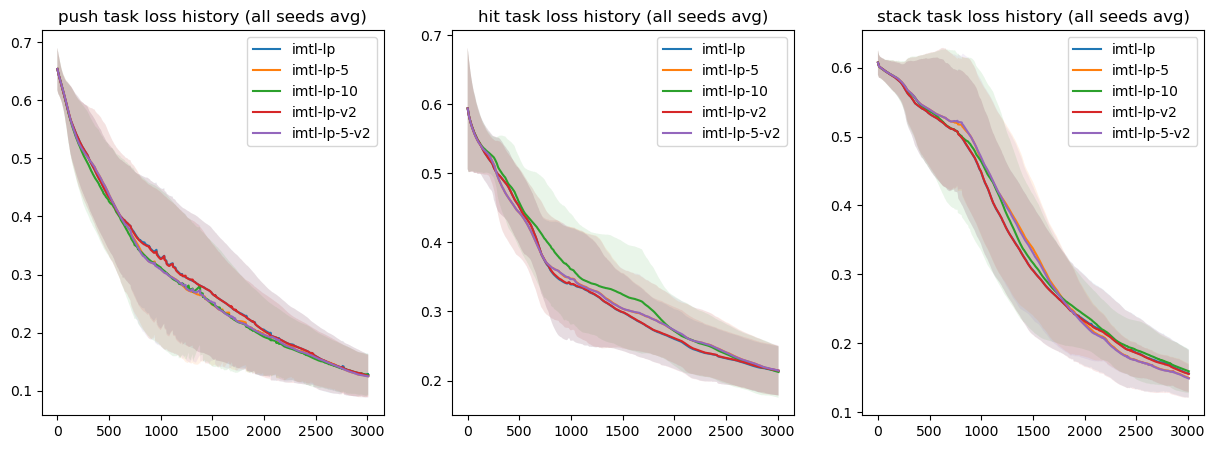

<Figure size 640x480 with 0 Axes>

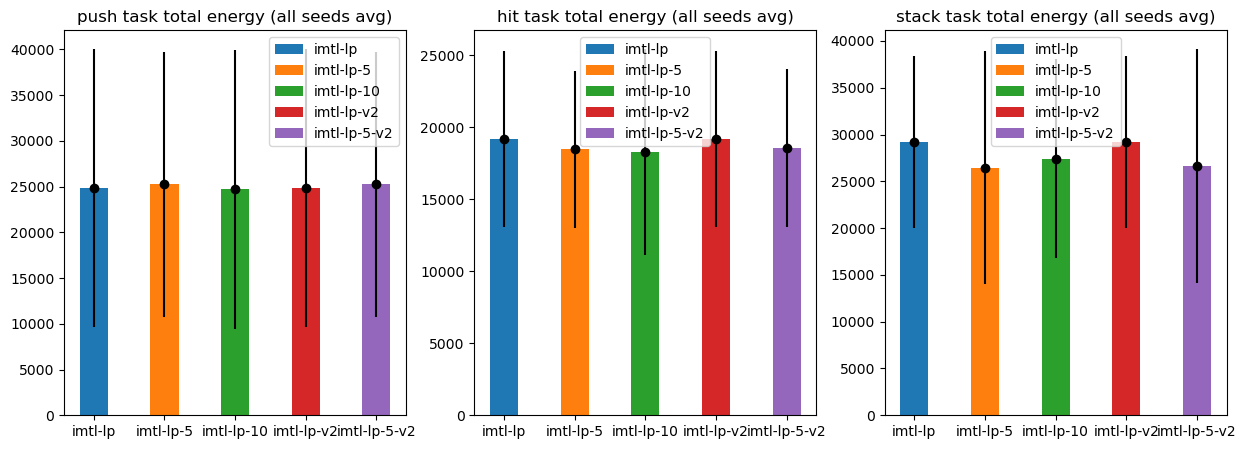

In [8]:
# Task specific plots
plt.figure(2)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
axes = [ax1, ax2, ax3]
tasks_loss_mean = np.mean(task_losses_seeds, axis=0)
tasks_loss_std = np.std(task_losses_seeds, axis=0)
for i, task in enumerate(tasks):
    for j, model in enumerate(models):
        axes[i].plot(range(epoch + pre_train), tasks_loss_mean[j][i], label="{}".format(model))
        axes[i].fill_between(range(epoch + pre_train), tasks_loss_mean[j][i] - tasks_loss_std[j][i],
                             tasks_loss_mean[j][i] + tasks_loss_std[j][i], alpha=0.1)
    axes[i].legend()
    axes[i].set_title('{} task loss history (all seeds avg)'.format(task))
# plt.savefig("plotresults/task-losses.png")
plt.show()

plt.figure(3)
f, (ax4, ax5, ax6) = plt.subplots(1, 3, figsize=(15, 5))
axes2 = [ax4, ax5, ax6]
tasks_energy_mean = np.mean(task_energies_seeds, axis=0)
tasks_energy_std = np.std(task_energies_seeds, axis=0)
for i, task in enumerate(tasks):
    for j, model in enumerate(models):
        axes2[i].bar(model, tasks_energy_mean[j][i], width=0.4, label="{}".format(model))
        axes2[i].errorbar(model, tasks_energy_mean[j][i], yerr=tasks_energy_std[j][i], fmt="o", color="black")
    axes2[i].legend()
    axes2[i].set_title('{} task total energy (all seeds avg)'.format(task))
# plt.savefig("plotresults/task-energies.png")
plt.show()
